<a href="https://colab.research.google.com/github/Ixiondbz/CSE499/blob/main/NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./


# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

!apt-get install python3-openslide
from openslide import open_slide

import plotly.express as px

from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset

In [3]:
import json
from pathlib import Path

from google.colab import drive
drive.mount('/drive')

folder = "MyDrive/MIDOG_Challenge"
midog_folder = Path("/drive") / Path(folder)
print(list(midog_folder.glob("*.*")))

image_folder = Path("/content/drive/MyDrive/CSE499 Project/train_images")

hamamatsu_rx_ids = list(range(0, 51))
hamamatsu_360_ids = list(range(51, 101))
aperio_ids = list(range(101, 151))
leica_ids = list(range(151, 201))


annotation_file = midog_folder / "MIDOG.json"
rows = []

Mounted at /drive
[PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.sqlite'), PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.json')]


In [ ]:
with open(annotation_file) as f:
    data = json.load(f)

    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        scanner  = "Hamamatsu XR"
        if image_id in hamamatsu_360_ids:
            scanner  = "Hamamatsu S360"
        if image_id in aperio_ids:
            scanner  = "Aperio CS"
        if image_id in leica_ids:
            scanner  = "Leica GT450"
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, scanner])
        
df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "scanner"])

In [ ]:
df[df['cat']=='hard negative'].index

Int64Index([   0,    1,    2,    3,    4,    7,   10,   11,   14,   15,
            ...
            4420, 4422, 4423, 4424, 4425, 4426, 4430, 4432, 4433, 4434],
           dtype='int64', length=2714)

In [ ]:
df.drop(df[df['cat']=='hard negative'].index,inplace=True)

In [ ]:
df

,file_name,image_id,width,height,box,cat,scanner
5,002.tiff,2,7215,5412,"[4397, 191, 4447, 241]",mitotic figure,Hamamatsu XR
6,002.tiff,2,7215,5412,"[1842, 1558, 1892, 1608]",mitotic figure,Hamamatsu XR
8,002.tiff,2,7215,5412,"[5319, 3252, 5369, 3302]",mitotic figure,Hamamatsu XR
9,002.tiff,2,7215,5412,"[6242, 3193, 6292, 3243]",mitotic figure,Hamamatsu XR
12,002.tiff,2,7215,5412,"[4636, 4294, 4686, 4344]",mitotic figure,Hamamatsu XR
...,...,...,...,...,...,...,...
4421,150.tiff,150,6467,4862,"[5373, 2398, 5423, 2448]",mitotic figure,Aperio CS
4427,150.tiff,150,6467,4862,"[3698, 3258, 3748, 3308]",mitotic figure,Aperio CS
4428,150.tiff,150,6467,4862,"[308, 4254, 358, 4304]",mitotic figure,Aperio CS
4429,150.tiff,150,6467,4862,"[553, 4394, 603, 4444]",mitotic figure,Aperio CS


In [ ]:
dataset_1 = df[df['scanner']=='Hamamatsu XR']
dataset_2 = df[df['scanner']=='Hamamatsu S360']
dataset_3 = df[df['scanner']=='Aperio CS']
#dataset_4 = df[df['scanner']=='Leica GT450']

In [ ]:
len(dataset_1['image_id'].unique())+len(dataset_2['image_id'].unique())+len(dataset_3['image_id'].unique())

135

In [ ]:
image_folder = Path("/content/drive/MyDrive/CSE499 Project/train_images")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# img_id = 2
# thumbail_size_big = 1024
# slide = open_slide( str(image_folder / f"{img_id:03d}.tiff") )

# image = slide.get_thumbnail((1443, 1082))

# fig = px.imshow(image)

# scale_x = slide.level_dimensions[0][0] / image.size[0]
# scale_y = slide.level_dimensions[0][1] / image.size[1]

# for id, anno in dataset_1[dataset_1["image_id"] == img_id].iterrows():

#     x0, y0, x1, y1 = anno.box[0] / scale_x, anno.box[1] / scale_y, anno.box[2] / scale_x, anno.box[3] / scale_y


#     fig.add_shape(
#         type='rect',
#         x0=x0, x1=x1, y0=y0, y1=y1,
#         xref='x', yref='y',
#         line_color='red' if "mitotic" in anno["cat"] else "blue"
#     )

# fig.update_layout(
#     autosize=False,
#     width=image.size[0],
#     height=image.size[1],
#     )

# fig.show()    

In [4]:
DataFrame = pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR/DataFrame.pkl')

In [5]:
for i in range(541):
  xmin,ymin,xmax,ymax = DataFrame.box[i]
  if xmin>=xmax or ymin>=ymax:
    print(i)
    break

In [6]:
class MitosisImagesDataset(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height,transforms=None):
    self.transforms = transforms
    self.files_dir  = files_dir
    self.height     = height
    self.width      = width

    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-5:]=='.tiff']
    
    self.classes = [_, 'mitotic figure']

  def __getitem__(self, idx):
    img_name   = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img     = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

    img_res /= 255.0
    
    
    dataframe = DataFrame[DataFrame['file_name']==img_name].copy()
    
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]
    
    for index in dataframe.index:
      labels.append(1)
      
      List = dataframe['box'][index]
      
      scale_x = 7215/self.width
      scale_y = 5412/self.height

      xmin = List[0]#/scale_x
      xmax = List[2]#/scale_x
      ymin = List[1]#/scale_y
      ymax = List[3]#/scale_y
        
      xmin_corr = (xmin)
      xmax_corr = (xmax)
      ymin_corr = (ymin)
      ymax_corr = (ymax)
          
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    


    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target
    
  def __len__(self):
    return len(self.imgs)

In [7]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()

In [8]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [9]:
files_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR'
test_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR'

In [10]:
dataset =      MitosisImagesDataset(files_dir, 481, 451)
dataset_test = MitosisImagesDataset(files_dir, 481, 451)

In [ ]:
target

{'area': tensor([2500.]),
 'boxes': tensor([[399., 205., 449., 255.]]),
 'image_id': tensor([1]),
 'iscrowd': tensor([0]),
 'labels': tensor([1])}

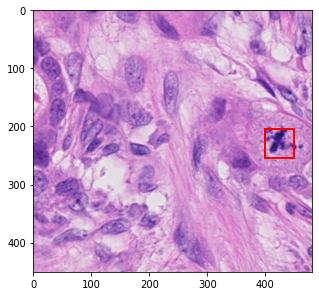

In [11]:
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[1]
plot_img_bbox(img, target)

In [ ]:
dataset[28]

(tensor([[[0.7922, 0.8314, 0.8667,  ..., 0.7961, 0.7216, 0.8039],
          [0.7804, 0.8196, 0.8314,  ..., 0.7765, 0.7333, 0.7490],
          [0.7882, 0.8078, 0.8157,  ..., 0.8314, 0.7725, 0.7608],
          ...,
          [0.8353, 0.8824, 0.9294,  ..., 0.7490, 0.8627, 0.7765],
          [0.9059, 0.9020, 0.8863,  ..., 0.7098, 0.7294, 0.7686],
          [0.9098, 0.8902, 0.8627,  ..., 0.7020, 0.7451, 0.7686]],
 
         [[0.3490, 0.3647, 0.3804,  ..., 0.5216, 0.5686, 0.6863],
          [0.3686, 0.3961, 0.3922,  ..., 0.5882, 0.5059, 0.5569],
          [0.3922, 0.4000, 0.3961,  ..., 0.6196, 0.5294, 0.5333],
          ...,
          [0.6039, 0.6588, 0.7137,  ..., 0.4078, 0.4118, 0.4275],
          [0.6667, 0.6588, 0.6431,  ..., 0.3216, 0.4000, 0.4235],
          [0.6863, 0.6627, 0.6235,  ..., 0.3137, 0.3608, 0.3882]],
 
         [[0.6549, 0.6784, 0.7098,  ..., 0.8078, 0.8157, 0.8902],
          [0.7333, 0.7333, 0.7137,  ..., 0.6902, 0.7333, 0.8118],
          [0.7529, 0.7333, 0.7176,  ...,

In [36]:
train_dataset =      MitosisImagesDataset(files_dir, 481, 451,transforms=get_transform(train=True))

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader  = DataLoader(train_dataset,batch_size=10,shuffle=True,num_workers=4,collate_fn=utils.collate_fn)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [38]:
device

device(type='cuda')

In [ ]:
# from matplotlib import pyplot as plt 

# images,targets = next(iter(train_data_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

# boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
# img = images[0].permute(1,2,0).cpu().numpy()
# fig,ax = plt.subplots(1, 1, figsize=(50,30))

# for box in boxes:
#   cv2.rectangle(img,
#                 (box[0],box[1]),
#                 (box[2],box[3]),
#                 (220,0,0), 1)

# ax.set_axis_off()
# ax.imshow(img)

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes=2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
model = model.to(device)

In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

In [ ]:
itr = 1

for epoch in range(num_epochs):
  for images,targets in train_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

    loss_dict = model(images,targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 50 == 0:
      print(f"Iteration #{itr} loss: {loss_value}")

    itr+=1

    lr_scheduler.step()

  print(f"Epoch #{epoch} loss: {loss_value}")

Epoch #0 loss: 1.278481364250183
Epoch #1 loss: 1.038503646850586
Epoch #2 loss: 0.7167458534240723
Epoch #3 loss: 1.0711729526519775
Epoch #4 loss: 0.8949969410896301
Epoch #5 loss: 0.8229814767837524
Epoch #6 loss: 0.8153839707374573
Epoch #7 loss: 0.9438090324401855
Epoch #8 loss: 0.7520048022270203
Iteration #50 loss: 1.083060622215271
Epoch #9 loss: 1.083060622215271
Epoch #10 loss: 0.8516127467155457
Epoch #11 loss: 0.8825467824935913
Epoch #12 loss: 1.0694729089736938
Epoch #13 loss: 0.6851437091827393
Epoch #14 loss: 1.135145664215088
Epoch #15 loss: 0.8707451820373535
Epoch #16 loss: 0.98777174949646
Epoch #17 loss: 0.7367779016494751
Epoch #18 loss: 0.7707308530807495
Iteration #100 loss: 0.9232560396194458
Epoch #19 loss: 0.9232560396194458


In [39]:
num_epochs = 20

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:01:54  lr: 0.000107  loss: 0.1431 (0.1431)  loss_classifier: 0.0501 (0.0501)  loss_box_reg: 0.0816 (0.0816)  loss_objectness: 0.0095 (0.0095)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 2.2979  data: 0.9757  max mem: 7973
Epoch: [0]  [10/50]  eta: 0:00:53  lr: 0.001126  loss: 0.1431 (0.1523)  loss_classifier: 0.0494 (0.0498)  loss_box_reg: 0.0765 (0.0748)  loss_objectness: 0.0142 (0.0177)  loss_rpn_box_reg: 0.0060 (0.0099)  time: 1.3307  data: 0.1301  max mem: 7973
Epoch: [0]  [20/50]  eta: 0:00:38  lr: 0.002146  loss: 0.1374 (0.1484)  loss_classifier: 0.0449 (0.0480)  loss_box_reg: 0.0740 (0.0733)  loss_objectness: 0.0142 (0.0181)  loss_rpn_box_reg: 0.0060 (0.0090)  time: 1.2301  data: 0.0449  max mem: 7973
Epoch: [0]  [30/50]  eta: 0:00:25  lr: 0.003165  loss: 0.1480 (0.1510)  loss_classifier: 0.0499 (0.0504)  loss_box_reg: 0.0740 (0.0743)  loss_objectness: 0.0141 (0.0180)  loss_rpn_box_reg: 0.0045 (0.0083)  time: 1.2305  data: 0.0457  max mem: 7973
Epoch: [

In [19]:
%cd '/drive/MyDrive/CSE499 Project/modelSaves'

/drive/.shortcut-targets-by-id/1M-kTVs7g43FucvCjcPvKwiR8r1e1qtHe/CSE499 Project/modelSaves


In [20]:
torch.save(model.state_dict(), 'model.pth')

torch.save({
'epoch':epoch,
'model_state_dict':model.state_dict(),
'optimizer_state_dict':optimizer.state_dict(),
},'ckpt.pth')

In [40]:
test_dataset = MitosisImagesDataset(files_dir, 481, 451,transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(test_dataset)*test_split)

test_dataset = torch.utils.data.Subset(test_dataset, indices[-tsize:])

test_data_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=10,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

In [41]:
evaluate(model, test_data_loader, device=device)

creating index...
index created!
Test:  [ 0/10]  eta: 0:00:16  model_time: 0.6237 (0.6237)  evaluator_time: 0.0087 (0.0087)  time: 1.6851  data: 1.0200  max mem: 7973
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.5761 (0.5711)  evaluator_time: 0.0083 (0.0093)  time: 0.7265  data: 0.1361  max mem: 7973
Test: Total time: 0:00:07 (0.7362 s / it)
Averaged stats: model_time: 0.5761 (0.5711)  evaluator_time: 0.0083 (0.0093)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU

In [ ]:
!ls -al

total 484161
-rw------- 1 root root 330055011 Jan  6 07:50 ckpt.pth
-rw------- 1 root root 165725683 Jan  6 07:50 model.pth


In [ ]:
model.load_state_dict(torch.load('./model.pth'))
model = model.to(device)

In [25]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep]
  final_prediction['scores'] = final_prediction['scores'][keep]
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

In [42]:
test_dataset = MitosisImagesDataset(files_dir, 481, 451, transforms = get_transform(train=False))

Predicted labels

MODEL OUTPUT



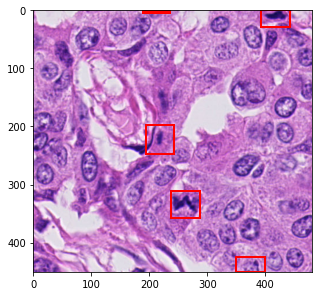

In [61]:
# pick one image from the test set
img, target = test_dataset[30]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]
    
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

Ground Truth labels

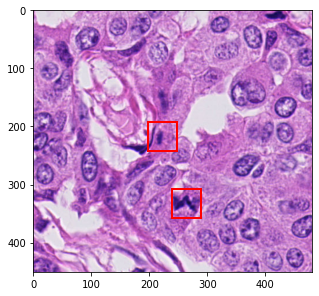

In [60]:
img, target = dataset[30]
plot_img_bbox(img, target)

for images,targets in metric_logger.log_every(test_data_loader, 20, "Test:"):
  images = list(img.to(device) for img in images)
  outputs = model(images)

In [ ]:
images[0]

tensor([[[0.6902, 0.6588, 0.6588,  ..., 0.4353, 0.4549, 0.5059],
         [0.7020, 0.6431, 0.6471,  ..., 0.5020, 0.5098, 0.5569],
         [0.6902, 0.6510, 0.6549,  ..., 0.5608, 0.5647, 0.6039],
         ...,
         [0.4392, 0.4353, 0.5059,  ..., 0.6235, 0.5294, 0.4275],
         [0.4824, 0.4941, 0.5647,  ..., 0.6275, 0.5333, 0.4431],
         [0.5020, 0.5647, 0.6314,  ..., 0.6118, 0.5176, 0.4353]],

        [[0.4235, 0.4471, 0.4431,  ..., 0.3843, 0.3216, 0.2863],
         [0.4627, 0.4431, 0.4431,  ..., 0.4353, 0.3804, 0.3451],
         [0.4863, 0.4667, 0.4588,  ..., 0.4667, 0.4196, 0.3882],
         ...,
         [0.3333, 0.2863, 0.2824,  ..., 0.5216, 0.4745, 0.4157],
         [0.3490, 0.3059, 0.3137,  ..., 0.5098, 0.4588, 0.4118],
         [0.3529, 0.3255, 0.3412,  ..., 0.4863, 0.4353, 0.3961]],

        [[0.7647, 0.7765, 0.7725,  ..., 0.6549, 0.6510, 0.6667],
         [0.7765, 0.7373, 0.7373,  ..., 0.7098, 0.6902, 0.6902],
         [0.7765, 0.7412, 0.7373,  ..., 0.7569, 0.7216, 0.

In [ ]:
outputs[0]

{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
 'labels': tensor([], device='cuda:0', dtype=torch.int64),
 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}